# Methods using sparse matrices

In [1]:
###Libraries (not in function files)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
from dscribe.descriptors import SOAP
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

In [2]:
from GP_optimizable import GP_opt
from project_dataload import data_load, check_data, summarize_1

In [3]:
### rmse
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [4]:
###Data load and check
data_dir="./project_data/"
train, test = data_load(data_dir)

summary = summarize_1(train, test)
print('Max number of atoms',summary['max_number_of_atoms'])
print('shapes', train.shape, test.shape)

Max number of atoms 20
shapes (8000, 4) (4000, 3)


# SOAP fingerprints

In [5]:
### Fingerprints - with sparse=true

def soapmatrices(train, species, r_cut, n_max, l_max):
    soap = SOAP(
        species=species,
        r_cut=r_cut,
        n_max=n_max,
        l_max=l_max,
        average = 'inner'
    )  

    #Number of features in soap object
    num_feat = soap.get_number_of_features()
    
    soaps = np.zeros((len(train),num_feat))
    for i,atoms in enumerate(train.atoms):
        if i%1000 == 0:
            print(i)
        soaps[i,:] = soap.create(atoms)
    
    return soaps

species = summary['species']
r_cut = 6
n_max = 4
l_max = 4

soaps = soapmatrices(train, species, r_cut, n_max, l_max)

0
1000
2000
3000
4000
5000
6000
7000


In [6]:
#Check outputted matrices
print('Shape of SOAP fingerprint', soaps.shape)
print('sum of arbitrary fingerprint (is it non-zero?)')
print(np.sum(soaps[5000]))
np.sum(soaps[6110]!=0)


Shape of SOAP fingerprint (8000, 154380)
sum of arbitrary fingerprint (is it non-zero?)
158.51735076492352


179

In [7]:
#Converting to sparse
soaps_sparse = csr_matrix(soaps)
#delete unused var for ram
del soaps

In [8]:
#Creating target values
y = train['hform'].values

In [9]:
###Splitting sparse data
# Split 'training' data into a training set and a test set
X_train_sparse, X_test_sparse, y_train, y_test = train_test_split(soaps_sparse, y, test_size=0.2, random_state=251)

#Split training again to have set for hyperparam optimisation
X_train_hyper_sparse, X_test_hyper_sparse, y_train_hyper, y_test_hyper = train_test_split(X_train_sparse, y_train, test_size=0.8, random_state=251)

#Delete unused variabled for ram
del X_test_hyper_sparse
del y_test_hyper


Shape of split data:  (6400, 154380) (1600, 154380) (6400,) (1600,)
Shape of split data for hyperparams  (1280, 154380) (1280,)


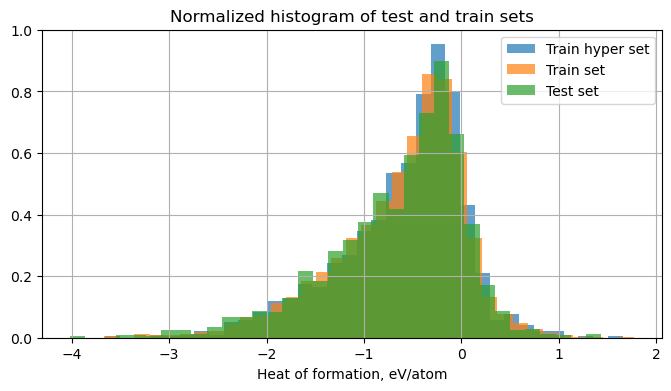

In [10]:
### Check split data
print('Shape of split data: ',X_train_sparse.shape, X_test_sparse.shape, y_train.shape, y_test.shape)
print('Shape of split data for hyperparams ',X_train_hyper_sparse.shape, y_train_hyper.shape)
N_train = X_train_sparse.shape[0]
N_test = y_train.shape[0]
N_hyper = X_train_hyper_sparse.shape[0]
N_feat_OG = X_train_sparse.shape[1]

plt.figure(figsize = (8, 4))
plt.hist(y_train_hyper, bins=35, alpha=0.7, density=True, label='Train hyper set')
plt.hist(y_train, bins=35, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=35, alpha=0.7, density=True, label='Test set')

plt.grid()
plt.title("Normalized histogram of test and train sets")
plt.xlabel("Heat of formation, eV/atom")
plt.legend()
plt.show()

# SVD to reduce dimensionality

In [11]:
# Initialize Truncated SVD
n_components = 1500  # Desired reduced dimensionality
svd = TruncatedSVD(n_components=n_components)

# Fit the SVD model on the sparse data
svd.fit(X_train_sparse)

# Transform the data
X_train_svd = svd.transform(X_train_sparse)
X_test_svd = svd.transform(X_test_sparse)
X_train_hyper_svd = svd.transform(X_train_hyper_sparse)


print("Shape of reduced data:", X_train_svd.shape, X_train_hyper_svd.shape, X_test_svd.shape)

Shape of reduced data: (6400, 1500) (1280, 1500) (1600, 1500)


In [12]:
### Variance check (as data is not centered, interpretation as variance is not necessarily exact, but its the best we can do)
# Approximate explained variance ratio
explained_variance_ratio = svd.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

print("Explained Variance Ratio (first 10 components): ", np.round(explained_variance_ratio[:10],3))
print("Cumulative Explained Variance (first 10 components):", np.round(cumulative_explained_variance[:10],3))
var_reduction = svd.explained_variance_ratio_.sum()
print(f"Total Explained Variance: {var_reduction:.4f}")

Explained Variance Ratio (first 10 components):  [0.256 0.084 0.093 0.066 0.049 0.036 0.034 0.019 0.019 0.019]
Cumulative Explained Variance (first 10 components): [0.256 0.34  0.433 0.498 0.548 0.583 0.617 0.637 0.656 0.675]
Total Explained Variance: 0.9984


# Hyperparams and training

In [13]:
### Hard-coded hyperparams
sigma = 0.1
k0 = 1

In [14]:
### Initiating gaussian process to train hyper params and real data
GP_hyper = GP_opt(X_train_hyper_svd, y_train_hyper)
GP_train = GP_opt(X_train_svd, y_train)

In [15]:
### Wrapper function for scipys optimize algorith
def optimize_hyper(params):
    GP_hyper.train_GP(params[0], k0, sigma)
    res = GP_hyper.calc_minusloglikelyhood() 
    return res

In [16]:
### Optimising for l
init_guess = [6.5]
bounds = [(0.01,1000)]

optimized_result = scipy.optimize.minimize(optimize_hyper, init_guess, bounds=bounds)


In [17]:
### Print results
print("Optimized parameters:", optimized_result.x[0])
print("Function value at optimum:", optimized_result.fun)
opt_params = [optimized_result.x[0]] # params = [l]
print(opt_params[0])

Optimized parameters: 49.42545168398237
Function value at optimum: 958.1375810239981
49.42545168398237


In [18]:
### Train on full set
GP_train.train_GP(opt_params[0], k0, sigma)


In [19]:
### Predict values with model
predictions = np.array([GP_train.predict(fingerprint) for fingerprint in X_test_svd])

In [20]:
### Predict errors 
#(NB have to update GP_optimizable.py script to include this funcitonality ...)

With l = 49.42545168398237, k0 = 1, sigma = 0.01  RMSE = 0.3473753520185545
-0.653402911508875


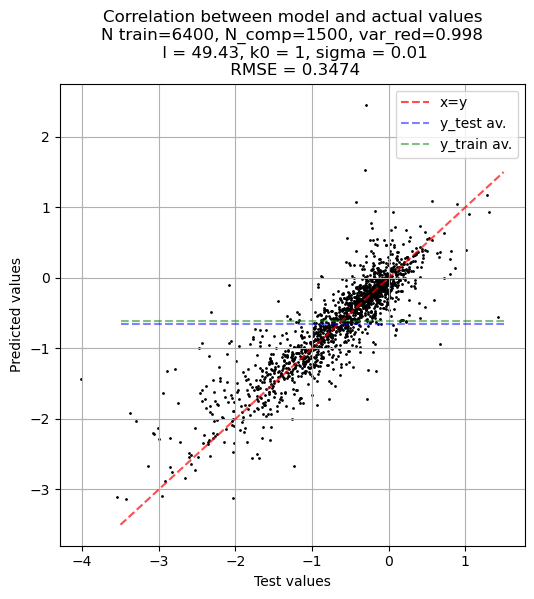

In [21]:
### Plot predictions and compare
print(f"With l = {opt_params[0]}, k0 = {k0}, sigma = {sigma}  RMSE = {rmse(y_test, predictions)}")

xlim = [-3.5, 1.5]
xg = np.linspace(xlim[0], xlim[1], 2)

fig, ax = plt.subplots(figsize=(6,6))

#Explanation of som params: N_comp: components used in reduction medthod (pca or svd).  var_red: varation explained of reduction medthod
ax.set_title(f'Correlation between model and actual values\nN train={X_train_svd.shape[0]}, N_comp={n_components}, var_red={var_reduction:.3f}\n l = {opt_params[0]:.2f}, k0 = {k0}, sigma = {sigma}\n RMSE = {rmse(y_test, predictions):.4f}')
ax.plot(xg,xg, color = 'red', linestyle = 'dashed', alpha=0.7, label='x=y')
ax.hlines(np.mean(y_test),xmin=xlim[0], xmax=xlim[1], linestyle = 'dashed', color='blue', alpha=0.5, label='y_test av.')
ax.hlines(np.mean(y_train),xmin=xlim[0], xmax=xlim[1], linestyle = 'dashed', color='green', alpha=0.5, label='y_train av.')
ax.scatter(y_test, predictions, s = 1,color='black')
ax.set_xlabel('Test values')
ax.set_ylabel('Predicted values')
ax.grid()
ax.legend()

print(np.mean(y_test))

